# Digital Signal Processing (DSP):
## Spectrograms Using the FFT
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Updated | 11/17/2019|

With the Fast-Fourier Transform, we can analyze signals in a variety of ways and explore their unique features—a major focus of _digital signal processing_ (DSP). DSP applications include: audio and speech processing, sonar, radar and other sensor array processing, spectral density estimation, statistical signal processing, digital image processing, data compression, video coding, audio coding, image compression, signal processing for telecommunications, control systems, biomedical engineering, seismology, etc.

An obvious, _time-varying_ signal that we're all familiar with is _sound_. In fact, we can get quite creative in analyzing samples of music or musical instruments. Let's start off with the simplest case: a single note, C3, plucked on a guitar. First we import the _waveform (wav)_ audio file.

In [1]:
from IPython.display import Audio
Audio('audio/guitar-C3.wav')

Next, we must "read in" the data in such a way we can then analyze it. Luckily, SciPy has a module just for that and returns the data as a NumPy array.

In [3]:
from scipy.io import wavfile as wav

rate, data = wav.read('audio/guitar-C3.wav')
print("Sample rate:", rate, "Hz")
print(data)
print (data.shape)

Sample rate: 44100 Hz
[[-1.2207031e-04  0.0000000e+00]
 [-5.4931641e-04 -4.8828125e-04]
 [-5.4931641e-04 -4.8828125e-04]
 ...
 [-9.1552734e-05 -3.0517578e-05]
 [ 6.1035156e-05  0.0000000e+00]
 [-6.1035156e-05 -9.1552734e-05]]
(196783, 2)


Before moving on, let's take a second to understand what the `.read()` function has returned.

### Question: What is a _sample rate_?

The first, `rate`, is an _int_ corresponding to the __sample rate__ of the wav file. In other words, it is the number of discrete "samples per second" that the real-world audio was recorded at. Humans can typically hear _continuous_, acoustic frequencies in the range of 20 - 20,000 Hz. However, a _digital_ (i.e., discrete) recording cannot fully capture a continuous signal, but can only take a series of samples. However, if the sample rate is too low, or infrequent, the capture of the original waveform will become distored, or _aliased_. To avoid this, as a consequence of the ___Nyquist theorem___, the sampling rate must be approximately _double the highest natural frequency_ of the signal we're interested in. Therefore, 44100 Hz, or 44.1 kHz, became the industry standard for compact discs (CDs) back when Sony used it in 1979.

<img src="img/nyquist_freq.png" alt="Nyquist Frequency and Aliasing" width="500" />

<center><b>FIG. 1:</b> <i>Various multiples of the Nyquist frequency, $f_{Nyq}$, for a 100 Hz sine wave, and the emergence of aliasing (<a href="https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform">source</a></i>).</ center><br />

### Bonus Question: Why does the data contain _two_ columns?

Moving on to the second object returned: why is `data` a _two_-dimentional array if the audio is simply a time-series of samples?

It's an (N, 2) array because it's a _stereo_ recording—one column for each left or right channel. Therefore, to make our following analysis simpler, let's convert to _mono_ by taking the average of the left and right channels.

In [4]:
import numpy as np

mono = np.mean(data, axis=1) # convert to mono

Next, let's compute the length of the audio snippet and plot the data.

Audio length: 4.46 sec


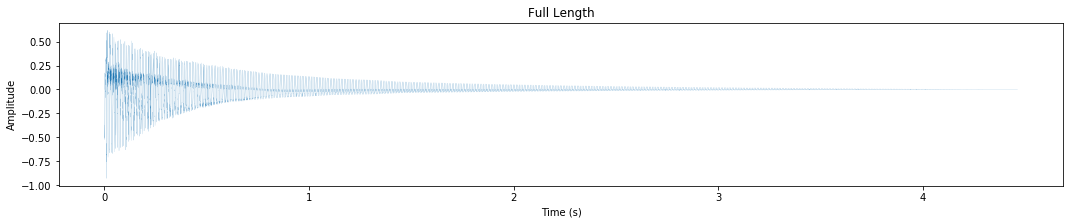

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

n_samples = mono.size
length = n_samples / rate

print(f'Audio length: {length:.2f} sec')

plt.figure(figsize=[18, 3])
plt.title("Full Length")
plt.plot(np.arange(n_samples) / rate, mono, lw=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

As we could hear, the overall intensity of the note fades as a function of time. But let's zoom in very close to see some detail on the note itself.

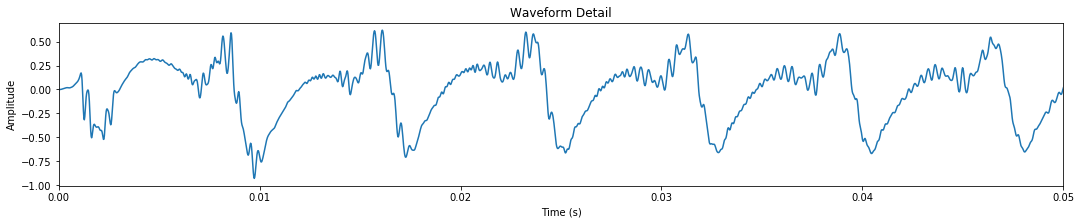

In [6]:
plt.figure(figsize=[18, 3])
plt.title("Waveform Detail")
plt.plot(np.arange(n_samples) / rate, mono)
plt.xlabel('Time (s)')
plt.xlim([0, 0.05])
plt.ylabel('Amplitude')
plt.show()

## Frequency Spectrum & Overtones (Harmonics)
As we learned in previous class lectures, we can apply the _discrete Fourier transform_ (DFT) to this waveform to determine its underlying component frequencies. Let's use SciPy's FFT to accomplish this over a smaller, sub-interval of the file, e.g., 4096 samples (recall that the recursive Cooley-Tukey algorithm is optimized for $N = 2^n, n \in \mathbb{Z}$, or powers of two).

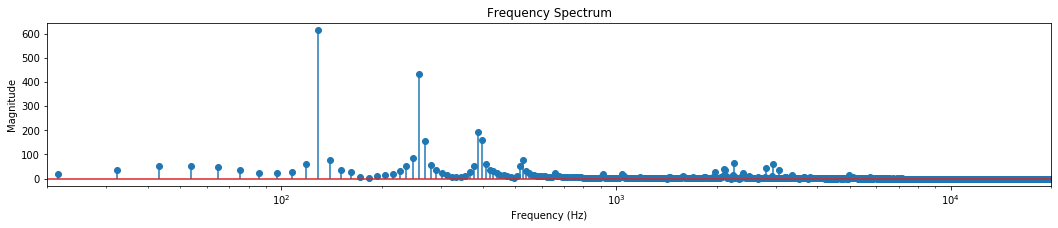

In [7]:
from scipy import fftpack

x = mono[0:4096] # take a smaller, sub-sample of the file
X = fftpack.fft(x)
f = fftpack.fftfreq(len(x)) * rate

plt.figure(figsize=[18, 3])
plt.title("Frequency Spectrum")
plt.stem(f, np.abs(X), use_line_collection=True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.xlim(20, 20000)
plt.show()

A semi-log, stem plot makes things clearer, especially since the sound spectrum can span several orders of magnitude (recall, humans' hearing range spans four). Notice that highest peak in the center? That's right around 130.813 Hz, which is exactly the note C3 (one octave below "middle C," 261.626 Hz). This is known as the _fundamental tone_ or _natural frequency_ of the note.

What about those other big peaks to the right, at higher frequencies but in order of decreasing magnitude? Those correspond to the _overtones_ or _harmonics_ and correspond to _multiples_ of the fundamental tone, e.g., 260 Hz, 390 Hz, 520 Hz, and so on. It's these overtones and their intensities that give an instrument it's unique ___timbre___, i.e., its distinctive quality or "color."

As great as this discrete Fourier transform is, this single _spectrum_ does not provide us with any information about _time_.

## Short-time Fourier Transform (STFT)

In order to find the frequency intensisties _as a function of time_, we'll need to apply a technique known as the __short-time Fourier transform__ (STFT). As the name implies, we'll perform a Fourier transform (or FFT, in fact) on just a _short_ time interval, or fixed sequence of samples. Then, we'll move further down the line (in time) and perform another FFT, making sure there's some _overlap_ in the slices. Figure 2 below provides a visual guide to the process.

<img src="img/elsp_0405.png" alt="STFT Slices" width="500" />
<center><b>FIG. 2:</b> <i>An example of Short-time Fourier Transform (STFT) with 1024-sample slices and 100-sample overlap (<a href=https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html">source</a>).</i></center><br />

Let's stick to 1024 samples per slice with an overlap of 100 samples.

In [8]:
from skimage import util # Image processing SciKit (Toolbox for SciPy)

M = 1024 # Number of samples per STFT slice

slices = util.view_as_windows(mono, window_shape=(M,), step=100)
print(f'Original audio shape: {mono.shape}\n  Sliced audio shape: {slices.shape}')

Original audio shape: (196783,)
  Sliced audio shape: (1958, 1024)


## "Windowing"
In signal processing and statistics, a ___window function___ is a _zero-valued_ function outside a chosen interval and generally symmetric around a maxmimum in the middle of the interval (e.g., "bell-shaped"). If we multiply another function, such as our waveform slices, by a window function, we force their product to also be zero outside the interval, leaving only the "view through the window."

By chopping the data up into a series of finite slices, or windows, we inadvertantly risk introduction of an effect known as _spectral leakage_: the creation of new and _artificial_ frequency components not present in the original signal (for example, the _aliasing_ we saw earlier in the case of sampling). By applying a window function, or "windowing," we can manage this leakage by distributing it in different ways.

Therefore, we'll generate a windowing function and then multiply it with our signal slices. Seen below, the _Hann window_ (based on the Hann function) is a popular window function.

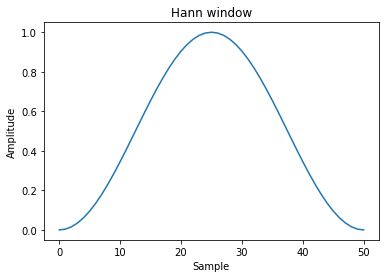

In [9]:
from numpy.fft import fft, fftshift
window = np.hanning(51)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

In [10]:
win = np.hanning(M + 1)[:-1]
slices = slices * win        # apply window function

## Spectrogram

Next, for convenience, we'll take the transpose of our array so we have one slice per column.

In [11]:
slices = slices.T
print('Shape of `slices`:', slices.shape)

Shape of `slices`: (1024, 1958)


Finally, we'll calculate the DFT (using FFT) for each slice. As you may have noticed, the DFT returns both positive and negative frequencies, so we'll slice out the positive frequencies for now.

In [12]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

We'll take the logarithm of intensities to compress its range, making it easier to analyze. And, we can go one step further and renormalize the data with respect to its maximum. In fact, $20\log_{10}\times$(intensity amplitude ratio) puts it in ___decibel___ units (see [_power gain level_ $L_G$](https://en.wikipedia.org/wiki/Decibel#Field_quantities_and_root-power_quantities)).

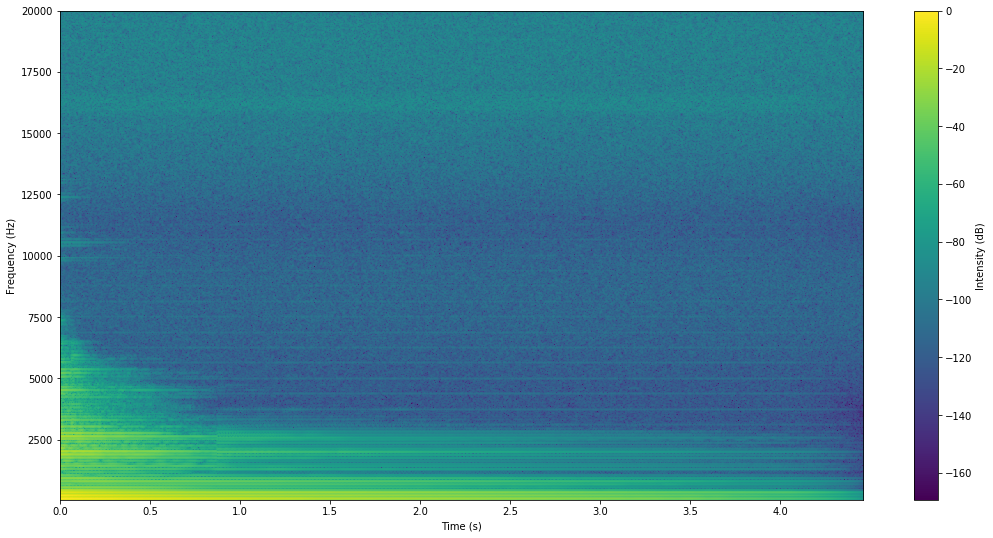

In [13]:
f, ax = plt.subplots(figsize=(18, 9))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

im = ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, length, 0, 20000))
ax.axis('tight')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
#ax.set_yscale('log') # uncomment to see freq. in semi-log scale
ax.set_ylim(45, 20000)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Intensity (dB)');

Now we see how the intensities of the frequencies vary over time. This is known as a ___spectrogram___ (a time-series of frequency spectra). Notice the higher frequency overtones, or harmonics, die off rapidly, while the natural frequency _resonates_ the longest. What we are seeing is this particular sound's—C3 on a clean electric guitar—_frequency and time signature_.

_Spectrograms_ are used extensively in the fields of music, sonar, radar, speech processing, seismology, and more. For example, spectrograms of audio can be used to analyze the various calls of animals and synthesize instruments and music.

## Blues Guitar Licks

Of course, after all that work, the final spectrogram for a single note was kind of boring. So, let's move on to something a bit more intricate and interesting: a series of different notes, or, in this case, a guitar _lick_.

In [14]:
Audio('audio/blues-guitar-lick.wav')

Audio length: 6.15 sec


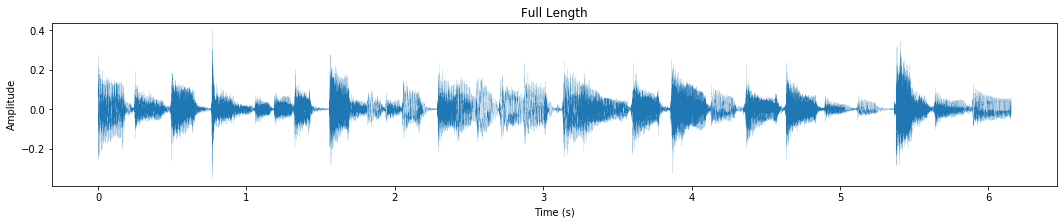

In [16]:
from scipy.io import wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

rate2, data2 = wav.read('audio/blues-guitar-lick.wav')
mono2 = np.mean(data2, axis=1)
length2 = mono2.size / rate2

print(f'Audio length: {length2:.2f} sec')

plt.figure(figsize=[18, 3])
plt.title("Full Length")
plt.plot(np.arange(mono2.size) / rate2, mono2, lw=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Fortunately, SciPy already includes the proceedure above in its `signal` module, called `scipy.signal.spectrogram()`. The main difference between the above version and SciPy's is that it returns the spectrum's magnitude _squared_ and multiplies it by some normalization factors. Here's how to use it.

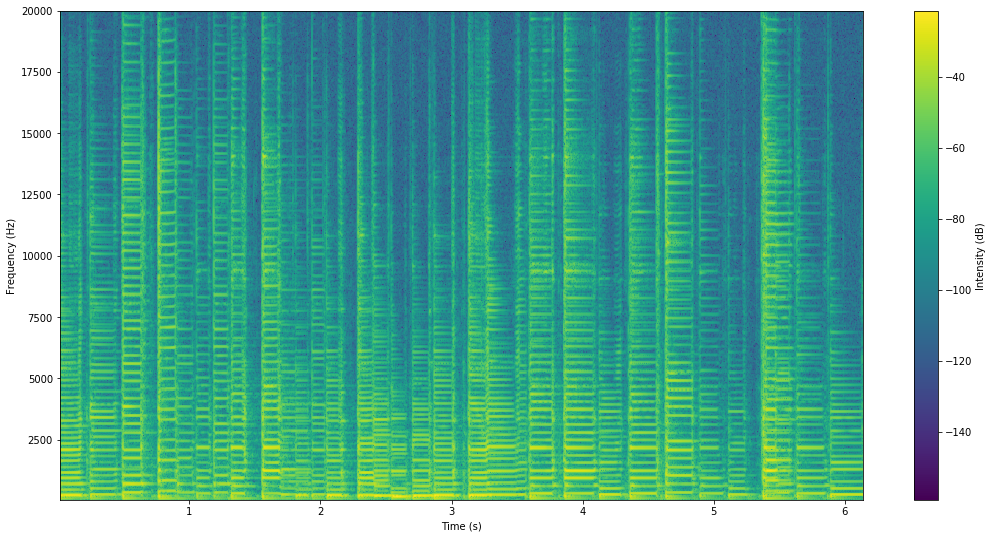

In [17]:
from scipy import signal

M = 1024
freqs2, times2, Sx2 = signal.spectrogram(mono2, fs=rate2, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(18, 9))
im = ax.pcolormesh(times2, freqs2, 10 * np.log10(Sx2), cmap='viridis')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')
#ax.set_yscale('log') # uncomment to see freq. in semi-log scale
ax.set_ylim(45, 20000)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Intensity (dB)');

A _much_ more interesting "map." We can see exactly _when_ each note was played and how their "signatures" differ from each other. Note how the harmonics of each note occur at _integer-multiples_ of the fundamental frequency at decreasing intensity.

Instead of using a variation of color to indicate intensity, let's try a 3-D plot to get a better picture of the sound's "landscape" through time, also known as a ___waterfall plot___.

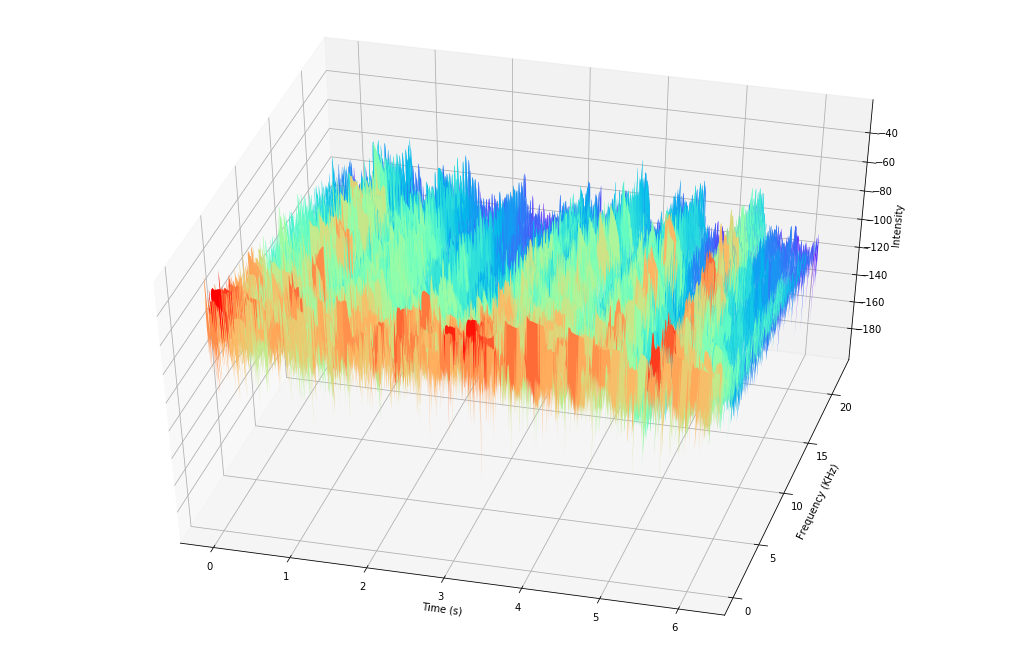

In [18]:
from mpl_toolkits.mplot3d import Axes3D

x2, y2 = np.meshgrid(times2, freqs2 / 1000)
z2 = 10 * np.log10(Sx2)

fig = plt.figure(figsize=[18,12])
ax = fig.gca(projection='3d', aspect="auto")
ax.plot_surface(x2, y2, z2, alpha=1.0, cmap="rainbow")
ax.view_init(elev=45, azim=-75)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (KHz)")
ax.set_zlabel("Intensity")
plt.show()

## Acknowledgements

I'd like to acknowledge and recommend visiting the following websites, as much of what was covered here draws from their discussions:
1. "Chapter 4. Frequency and the Fast Fourier Transform," in _Elegant SciPy_, by Harriet Dashnow, Stéfan van der Walt, Juan Nunez-Iglesias (https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html)

2. "Audio Processing in Python Part I: Sampling, Nyquist, and the Fast Fourier Transform," by Joshua Hrisko (https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform)

## Bonus Content

See appendices 1 (3D) and 2 (EQ) for more content.

Although my original goal was to produce something like this [here](https://musiclab.chromeexperiments.com/Spectrogram/) (albeit _far_ less dynamic) the following 4.3-second, _tiny_ 3-D animation of the first audio file's spectrogram took an hour to render using Matplotlib and IPython.

I really urge you to check our that link; it's an amazing, real-time spectrogram!

In [60]:
from scipy import signal

M = 1024
freqs, times, Sx = signal.spectrogram(mono, fs=rate, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

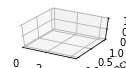

In [197]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

t = 0
jump = int(t * (1958 / 133))
x, y = np.meshgrid(times[:jump], freqs / 1000)
z = 10 * np.log10(Sx[:, :jump])

fig = plt.figure(figsize=[2,1])
ax = fig.gca(projection='3d', aspect="auto")
ax.plot_surface(x, y, z, alpha=1.0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (KHz)")
ax.set_zlabel("Intensity")
ax.set_xlim3d(0, length)
ax.view_init(elev=45, azim=-60)
plt.show()

In [198]:
# init function plots BG of each frame
def init():
    return fig,

# animation function called sequentially each frame
def animate(t):
    jump = int(t * (1958 / 133))
    x, y = np.meshgrid(times[:jump], freqs / 1000)
    z = 10 * np.log10(Sx[:, :jump])
    ax.plot_surface(x, y, z, alpha=1.0)
    return fig,

In [199]:
# call animator
anim = animation.FuncAnimation(fig, animate, init_func=init,
    frames=133, interval=33, blit=False, repeat=True)

# embed HTML5 video of animation
HTML(anim.to_html5_video())